# 画像生成 AI 入門: Python による拡散モデルの理論と実践

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shunk031/coloso-python-diffusion-models/blob/main/lectures/section-04-12.ipynb)

## Section 04. Key Researches Based on Non-Diffusion Models

"非"拡散モデルベースの手法や、拡散モデルを支える基盤モデルについて紹介します。

### Lecture 12. About CLIP (Contrastive Language-Image Pre-training)

CLIP モデルのダウンロードと実行、任意の画像とテキスト入力の類似度計算、zero-shot 画像分類の実行方法を紹介します。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Wed Jun 21 12:18:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

今回は diffusers は使いません。その代わりに diffusers でも使われていて、diffusers をメンテナンスしている huggingface 社の transformers を使用します。

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.5 MB/s eta 0:00:00


## CLIP モデルの読み込み

[🤗 Huggingface transformers](https://huggingface.co/docs/transformers/index) を使用して、 CLIP モデルによる zero-shot 画像分類（学習データには含まれていないような、完全に未知のデータを対象）に取り組みます。

以下、[Interacting with CLIP](https://github.com/openai/CLIP/blob/main/notebooks/Interacting_with_CLIP.ipynb) を参考に動作を追っていきます。ここではまず初めに `CLIPModel` で `openai/clip-vit-large-patch14` を読み込みます。その後、読み込んだモデルに対応するテキストと画像の処理を行う `CLIPProcessor` を読み込みます。

今回使用する事前学習済み CLIP モデル以外にも様々なものが [huggingface hub](https://huggingface.co/models?other=clip) 上で見つけることができます。

In [ ]:
from transformers import CLIPModel, CLIPProcessor

model_id = "openai/clip-vit-large-patch14"

# CLIP モデルの読み込み
model = CLIPModel.from_pretrained(model_id)

# モデルを推論モードにする
# このとき dropout を無効化したり、batch normalization の動作を推論用にする
model.eval()

# CLIP 用の前処理 pipeline の読み込み
processor = CLIPProcessor.from_pretrained(model_id)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


読み込んだモデルのパラメータ数、入力画像の解像度、入力テキストの最大長、語彙数を確認します。

In [ ]:
import numpy as np

print(f"Model parameters: {sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print(f"Input resolution: {model.config.vision_config.image_size}")
print(f"Context length: {processor.tokenizer.model_max_length}")
print(f"Vocab size: {model.config.text_config.vocab_size:,}")

Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49,408


## CLIPProcessor について

CLIP は画像とテキストを扱うマルチモーダルモデルです。それぞれのモダリティを適切に入力できるように、[`CLIPProcessor`](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPProcessor) を使用して統一的にマルチモーダルデータを扱います。

以下は `CLIPProcessor` の概要です。画像の前処理を司る `CLIPImageProcessor` とテキストの前処理を司る `CLIPTokenizerFast` が含まれています。

In [ ]:
processor

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-large-patch14', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedTok

### CLIPImageProcessor による画像処理

`CLIPProcessor` に含まれる画像処理機構 `CLIPImageProcessor` の動作を確認します。まずはサンプルとなる画像をダウンロードします。ここでは stable diffusion 本家レポジトリから画像を借りました。

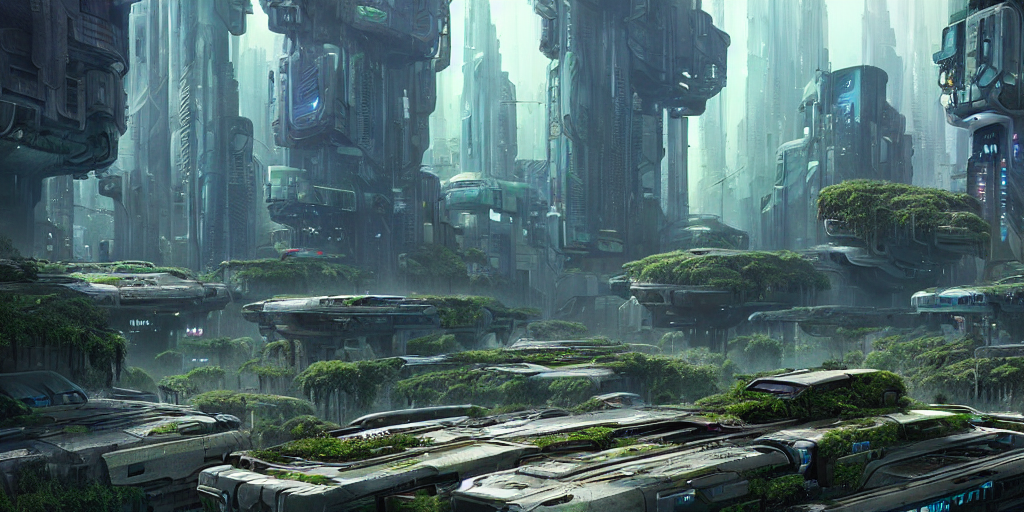

In [ ]:
import requests
from PIL import Image

image = Image.open(requests.get("https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/txt2img/000002025.png", stream=True).raw)
image

ダウンロードしたサンプル画像は 1024 x 512 の解像度を有しています。CLIP の入力解像度は 224 x 224 であるため、この画像はリサイズされるべきです。

In [ ]:
image.size

(1024, 512)

`CLIPImageProcessor` の機能を使って CLIP の入力に合うように前処理します。ここでは `CLIPProcessor` の `images` 引数に対象の画像を渡すことで、内部的に `CLIPImageProcessor` を用いて処理を行います。

In [ ]:
output = processor(images=image, return_tensors="pt")
output

{'pixel_values': tensor([[[[ 1.7260,  0.3391, -0.3908,  ...,  0.9376,  1.0106,  1.1566],
          [ 1.7406,  0.7917, -0.3616,  ...,  0.9230,  0.9668,  1.0690],
          [ 1.7114,  1.4194, -0.0550,  ...,  0.8938,  0.9084,  1.0252],
          ...,
          [-1.4565, -1.3689, -1.5003,  ..., -1.6609, -1.6317, -1.5441],
          [-1.5149, -1.4419, -1.4711,  ..., -1.6463, -1.6025, -1.4565],
          [-1.4857, -1.4711, -1.4273,  ..., -1.6463, -1.6025, -1.6025]],

         [[ 2.0449,  1.1294,  0.4540,  ...,  1.6847,  1.7297,  1.8348],
          [ 2.0299,  1.5046,  0.4841,  ...,  1.6847,  1.7147,  1.8047],
          [ 2.0149,  1.9398,  0.8442,  ...,  1.6697,  1.6997,  1.8047],
          ...,
          [-1.3169, -1.1818, -1.3469,  ..., -1.6170, -1.5570, -1.4820],
          [-1.3169, -1.2118, -1.3019,  ..., -1.6170, -1.5420, -1.3019],
          [-1.2568, -1.1818, -1.2568,  ..., -1.5870, -1.4970, -1.4219]],

         [[ 2.0037,  1.2785,  0.7523,  ...,  1.6909,  1.7051,  1.8046],
          [ 2

辞書型の `output` に含まれている `pixel_values` が前処理済みの画像です。以下のようにしてデータのサイズを確認すると、CLIP の入力に適した `224 x 224` のサイズになっていることがわかります。

In [ ]:
output["pixel_values"].size()

torch.Size([1, 3, 224, 224])

### CLIPTokenizer による言語処理

`CLIPProcessor` に含まれる言語処理機構 `CLIPTokenizer` の動作を確認します。ここでは `CLIPProcessor` の `text` 引数の対象のテキストを渡すことで、内部的に `CLIPTokenizer` を用いてテキストをトークンに分割します。

In [ ]:
output = processor(text="Hello world", return_tensors="pt")
output

{'input_ids': tensor([[49406,  3306,  1002, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

辞書型の `output` には、分割結果はそれぞれトークンの ID 列に変換され、`input_ids` というキーで格納されます。`attention_mask` というキーは、可変長のテキストに対応するための mask を表しています。長さが異なるテキストが processor に入力されたときに、padding 部分に mask するように 0/1 の値が返ってきます。

トークンの ID 列である `input_ids` は、processor のデコード機能を使って文字列に戻すことができます。`output` はバッチを想定したデータ構造（`input_ids` のサイズが `(batch_size, sequence_length)`）になっているため、以下では [`processor.batch_decode`](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPProcessor.batch_decode) を使用してデコードしています。

In [ ]:
processor.batch_decode(output["input_ids"])

['<|startoftext|>hello world <|endoftext|>']

CLIP では大文字・小文字を区別しない tokenizer を使用しているため、大文字だったところが小文字になっている点を除いては、もともとのテキストを復元できているように見えます。

CLIP で使用している tokenizer を始め、多くの tokenizer は学習用にテキストやセンテンスの始めを示す `<|startoftext|>` や `<BOS>` (begin of sentence) といったトークンや、テキストの終わりを示す `<|endoftext|>` や `<EOS>` (end of sentence) といったトークンを自動的に挿入します。

## 画像とテキストのセットアップ

以下、8枚の画像とそのテキストキャプションを CLIP モデルに与えて、対応する特徴ベクトルの類似度を比較していきます。

再度確認ですが、CLIP の tokenizer は大文字・小文字を区別しないので、以下のようにざっくりとした文章を自由に記述可能です。

In [ ]:
#
# 使用する skimage の画像とその説明文
#
descriptions_dict = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

[`skimage`](https://scikit-image.org/) から画像データを取得します。

In [ ]:
import os
import skimage

from more_itertools import sort_together
from PIL import Image

original_imgs = []
original_txts = []

# skimage から .png か .jpg な画像のパスを習得する
filenames = [
    filename for filename in os.listdir(skimage.data_dir)
    if filename.endswith(".png") or filename.endswith(".jpg")
]
for filename in filenames:
    name, _ = os.path.splitext(filename)
    if name not in descriptions_dict:
        continue

    # 画像の読み込み
    image_path = os.path.join(skimage.data_dir, filename)
    image = Image.open(image_path).convert("RGB")
    original_imgs.append(image)

    text = descriptions_dict[name]
    original_txts.append(text)

# 画像とテキストの数があっているか確認
assert len(original_txts) == len(original_imgs)
# テキストの文字列をベースに、テキストと画像のリストをソートする
original_txts, original_imgs = sort_together((original_txts, original_imgs))

読み込んだ画像とテキストのペアを確認してみます。

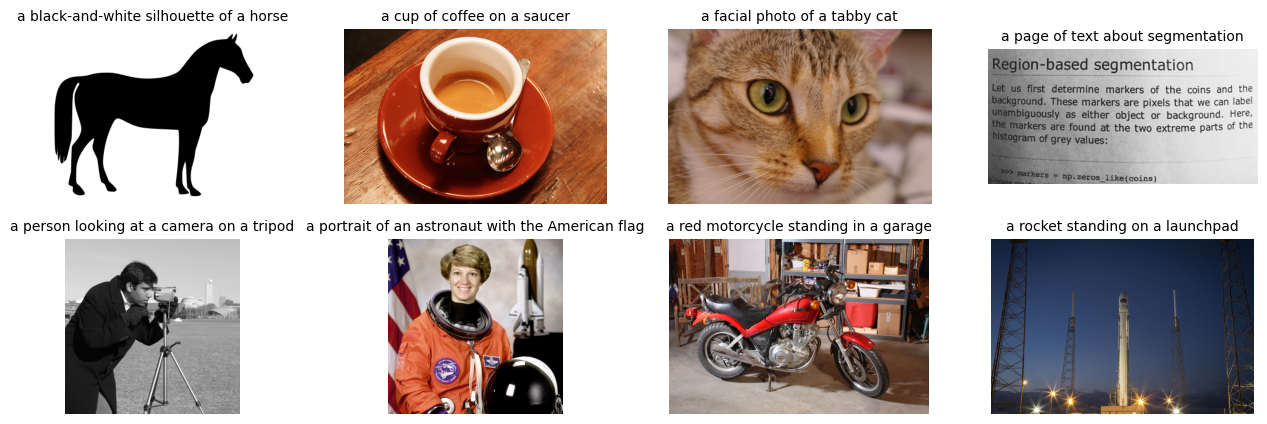

In [ ]:
import matplotlib.pyplot as plt

nrows = 2; ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5))

for i in range(nrows):
    for j in range(ncols):
        axes[i][j].imshow(original_imgs[i * ncols + j])
        axes[i][j].axis("off")
        axes[i][j].set_title(original_txts[i * ncols + j], fontsize=10)

## 特徴量の構築

CLIP モデルに画像とテキストを入力するため、`CLIPProcessor` を使用します。この processor は煩雑な複数のモダリティの前処理を以下の一行で完了します。

In [ ]:
inputs = processor(text=original_txts, images=original_imgs, padding="max_length", return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  1449,   268,   537,   268,  1579, 26149,   539,   320,
          4558, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406,   320,  1937,   539,  2453,   525,   320, 42272, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 

`CLIPModel` を利用して、画像特徴とテキスト特徴をそれぞれ計算します。

In [ ]:
import torch

with torch.no_grad():
    img_features = model.get_image_features(
        pixel_values=inputs["pixel_values"],
    )
    txt_features = model.get_text_features(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
    )

## コサイン類似度を計算する

上記で得られた特徴量を正規化し、各ペアの内積を計算します。

In [ ]:
img_features = img_features / img_features.norm(p=2, dim=-1, keepdim=True)
txt_features = txt_features / txt_features.norm(p=2, dim=-1, keepdim=True)

similarity = img_features @ txt_features.T

画像とテキスト、それぞれの類似度を以下のようにして可視化します。対角線上がもともと対応していた画像とテキストにおける類似度です。CLIP による特徴ベクトルを利用することで、画像とテキストの正しいペアの類似度が高くなっていることが確認できました。

Text(0.5, 1.0, 'Cosine similarity between text and image features')

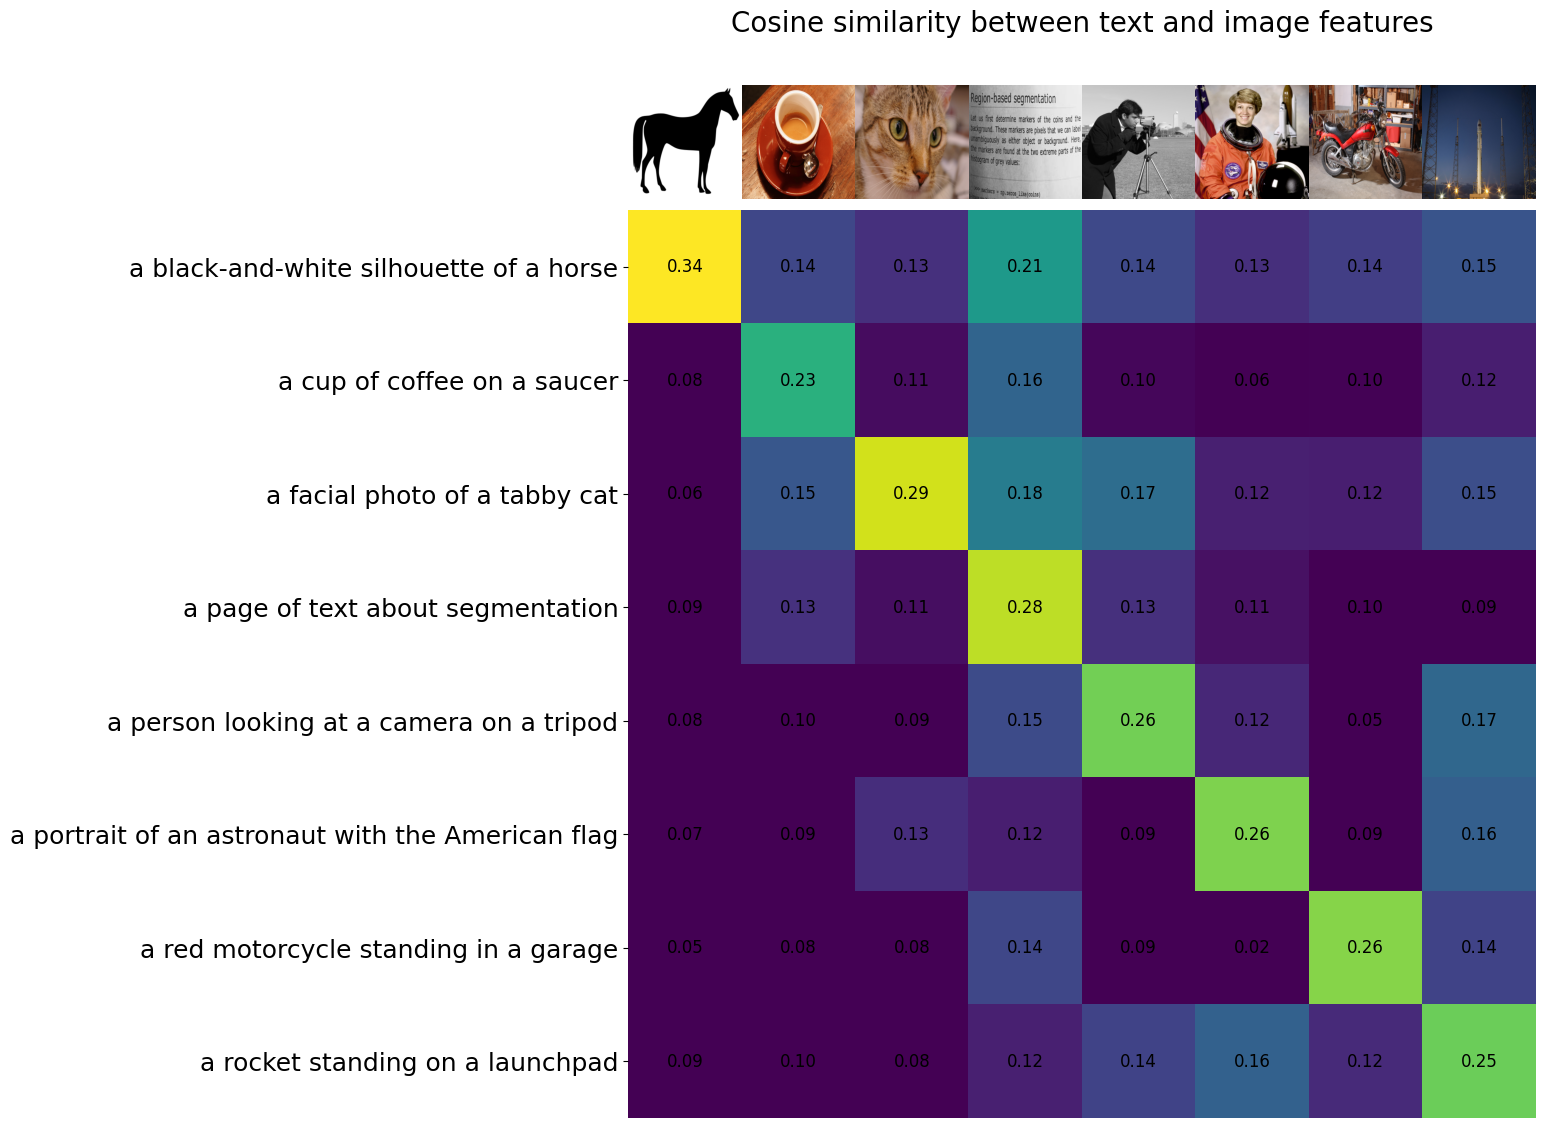

In [ ]:
assert len(original_imgs) == len(original_txts)
count = len(original_imgs)

fig, ax = plt.subplots(figsize=(20, 14))
ax.imshow(similarity, vmin=0.1, vmax=0.3)

ax.set_yticks(range(len(original_txts)), labels=original_txts, fontsize=18)
ax.set_xticks([])

for i, img in enumerate(original_imgs):
    ax.imshow(img, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        ax.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

ax.set_xlim([-0.5, count - 0.5])
ax.set_ylim([count - 0.5, -2])

ax.set_title("Cosine similarity between text and image features", size=20)

## Zero-shot 画像分類

CLIP は追加学習なしで未知の画像を分類することが可能です。以下では CIFAR100 と呼ばれる 100 クラスの画像分類データセットを用いて CLIP の zero-shot 画像分類性能について見ていきます。

まずは [`torchvision`](https://pytorch.org/vision/stable/index.html) を用いて CIFAR100 データセットを読み込みます。

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), download=True)

100%|██████████| 169001437/169001437 [00:13<00:00, 12737679.44it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


CLIP に入力するプロンプトとして、`This is a photo of a {label}` のようなテンプレート文を用意します。その後 CIFAR100 に存在するクラスでテンプレートを埋めた文のリストを得ます。

In [ ]:
text_template = "This is a photo of a {label}"
text_descriptions = [text_template.format(label=label) for label in cifar100.classes]

上記で用意したテキストのリストを元に、`CLIPProcessor` である processor でトークンへ変換します。その後 `CLIPModel` でテキストトークン列からテキスト特徴ベクトルを取得します。最後に取得したテキストベクトルを正規化しておきます。

In [ ]:
inputs = processor(text=text_descriptions, padding="max_length", return_tensors="pt")

with torch.no_grad():
    txt_features = model.get_text_features(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
    )
    txt_features = txt_features / txt_features.norm(p=2, dim=-1, keepdim=True)

画像とテキストの特徴ベクトルの内積を取り、そのスコアを 100 倍して softmax に通すことで、通常の分類モデルのような形で画像を分類できます。ここでは予測結果上位 5 件を選択しています。

In [ ]:
txt_probs = (100 * img_features @ txt_features.T).softmax(dim=-1)
top_probs, top_labels = txt_probs.topk(5, dim=-1)

これまでに得られた zero-shot 画像分類結果を以下に可視化します。画像とそれに紐づくキャプションと、zero-shot 分類したときの予測結果上位 5 件を示しています。

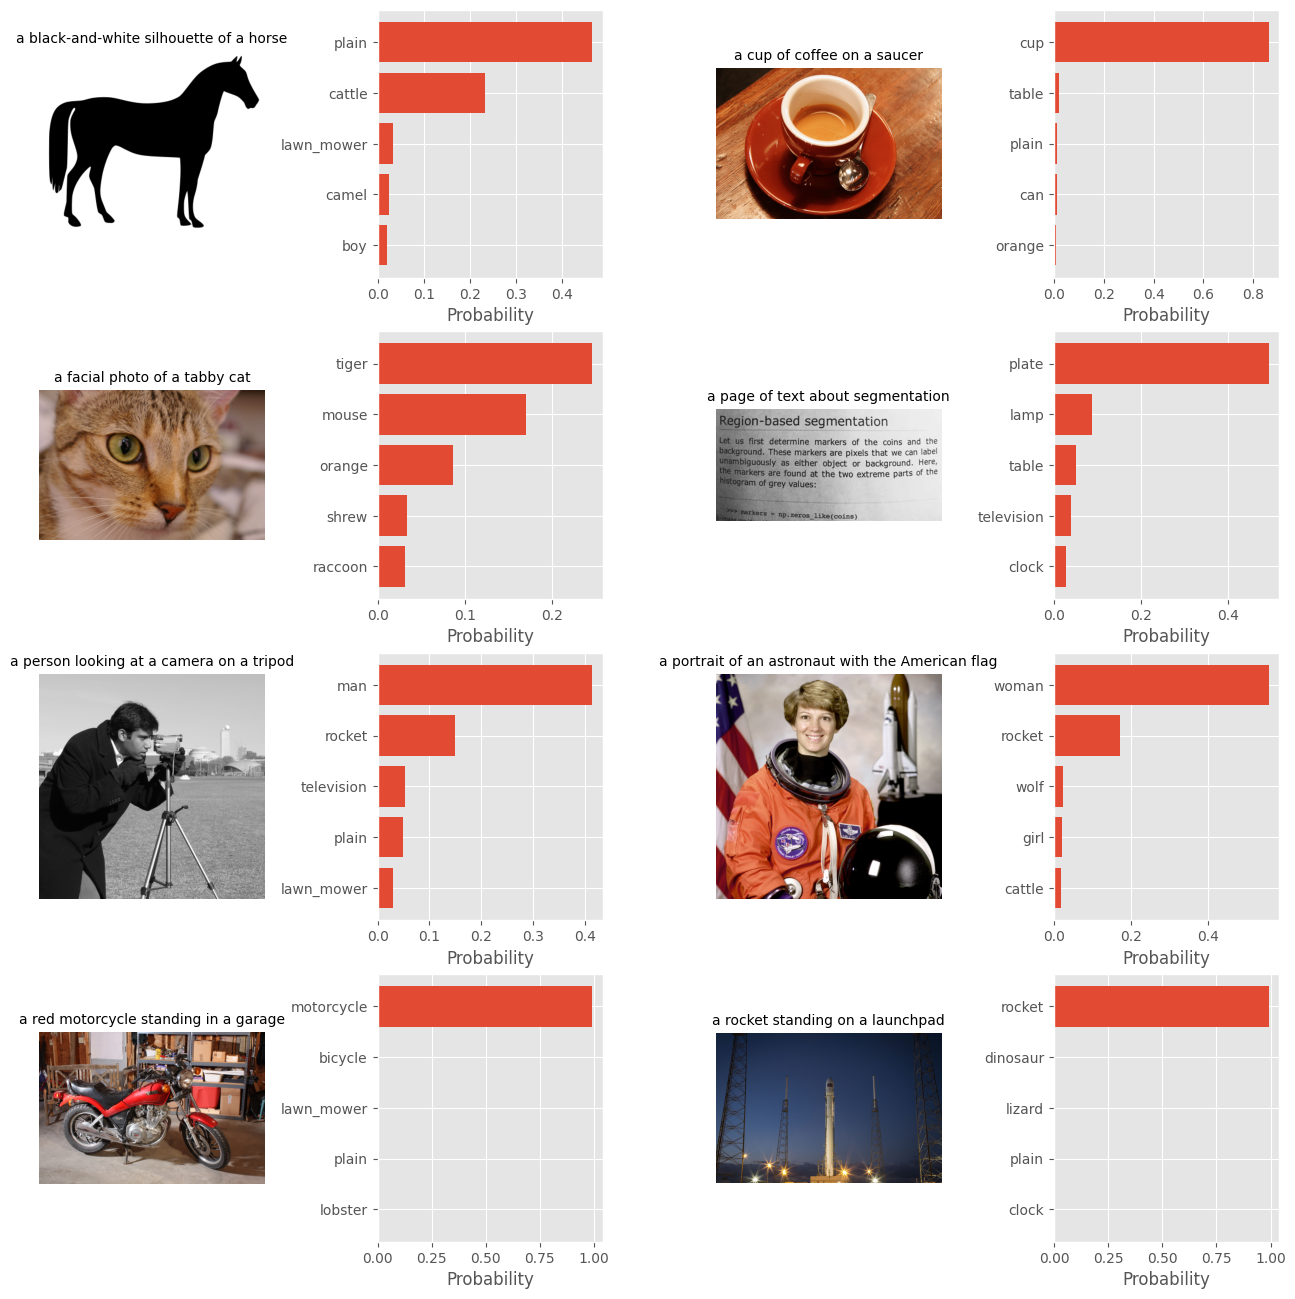

In [ ]:
nrows = 4; ncols = 4
fig = plt.figure(figsize=(16, 16))
plt.style.use("ggplot")

y = np.arange(top_probs.shape[-1])

for i, img in enumerate(original_imgs):
    ax1 = fig.add_subplot(nrows, ncols, 2 * i + 1)
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title(original_txts[i], fontsize=10)

    ax2 = fig.add_subplot(nrows, ncols, 2 * i + 2)
    ax2.barh(y, top_probs[i])

    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    ax2.set_yticks(y, [cifar100.classes[idx] for idx in top_labels[i]])
    ax2.set_xlabel("Probability")

fig.subplots_adjust(wspace=0.5)

男 (man)・女 (woman) のレベルでは zero-shot で適切に予測が可能なように見えます。猫が虎として予測されてしまっているのは仕方がなさそうですね。カップやバイク、ロケットが高い確信度で予測が出力されているのは素晴らしいですね。